In [ ]:
## TRAINING  and TEST SET :  miRNA DATA , MODEL: XGBoost

In [26]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

#np.random.seed(7)

# Data Preprocessing

In [88]:
df = pd.read_csv("DS/miRNA_DS_preprocessed_data.csv") # read the data

In [89]:
df.shape

(230, 239)

In [90]:
df = df.T # transpose the data

In [91]:
#Transform the input data
df.rename(columns=df.iloc[0], inplace = True)
df.drop(df.index[0], inplace = True)
df=df.reset_index()

In [92]:
metadata = pd.read_csv("DS/miRNA_DS_metadata_col_info.csv") # read the class information

In [93]:
df= df.merge(metadata, left_on="index", right_on= "Unnamed: 0") # merge the expresison data with class info

In [94]:
df['title0'] = df['title0'].replace('(?i)mucosa|normal|healthy', 0, regex=True) # replace the class name 


In [95]:
df['title0'] = df['title0'].replace('(?i)Tumor|Cancer|carcinoma', 1, regex=True)

In [96]:
df = df[pd.to_numeric(df['title0'], errors='coerce').notnull()]#remove all non-numeric data from the column.

In [97]:
df= df.drop(['index', 'Unnamed: 0'], axis=1)

In [98]:
df= df.rename(columns={"title0": "index"})

In [99]:
df['index'].value_counts()

index
1    119
0    119
Name: count, dtype: int64

In [100]:
df= df.apply(pd.to_numeric)

In [101]:
df['index'].value_counts()

index
1    119
0    119
Name: count, dtype: int64

# t-SNE

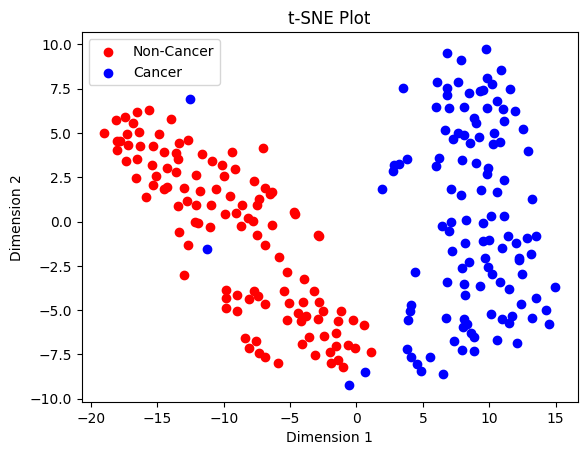

In [102]:
from sklearn.manifold import TSNE
#t-SNE
tsne = TSNE(n_components=2,perplexity=30)
embedded_data = tsne.fit_transform(df)

# Step 2: Separate data points by class
class_1_indices = np.where(df['index'] == 0)[0]
class_2_indices = np.where(df['index'] == 1)[0]

class_1_data = embedded_data[class_1_indices]
class_2_data = embedded_data[class_2_indices]

# Step 3: Plot the t-SNE plot with different colors for each class
plt.scatter(class_1_data[:, 0], class_1_data[:, 1], color='red', label='Non-Cancer')
plt.scatter(class_2_data[:, 0], class_2_data[:, 1], color='blue', label='Cancer')

plt.title('t-SNE Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

#### t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two dimensional map.  In the plot above we used perplexity of 30 for visualizing the t-SNE, but we didnt do any dimensionality reduction with it. Blue points are Cancer and the red are non-cancer.

In [103]:
X=df.drop("index",axis=1)
y=df['index']

In [104]:
y=y.astype('int')

# Test train split

In [105]:
# split data into training and testing data-sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [106]:
y_test.value_counts(),y_train.value_counts()

(index
 0    30
 1    30
 Name: count, dtype: int64,
 index
 0    89
 1    89
 Name: count, dtype: int64)

# Cross validation

In [107]:
model = xgb.XGBClassifier(random_state=42)

# Defining parameter range
param_grid = {
    'max_depth': [3,5],
    'learning_rate': [0.1 ,0.01, 0.001],
    'n_estimators': [100,200],
    'gamma': [ 0.1,0.01,0.001],
    'subsample': [1.0]
}


grid = GridSearchCV(model, param_grid, refit=True, verbose=3)

# Fitting the model for grid search
grid.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time=   0.6s
[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time=   0.1s
[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.972 total time=   0.2s
[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.971 total time=   0.1s
[CV 5/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.971 total time=   0.2s
[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=1.000 total time=   0.6s
[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=1.000 total time=   0.3s
[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, s

[CV 3/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=0.972 total time=   0.3s
[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=0.971 total time=   0.3s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=0.971 total time=   0.3s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=1.000 total time=   0.2s
[CV 2/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=1.000 total time=   0.1s
[CV 3/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=0.972 total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=0.971 total time=   0.2s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=0.971 total time=   0.2s
[CV 1/5] END gamma=0.01,

[CV 1/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=1.000 total time=   0.2s
[CV 2/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=1.000 total time=   0.2s
[CV 3/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=0.972 total time=   0.2s
[CV 4/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=0.971 total time=   0.2s
[CV 5/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=0.971 total time=   0.2s
[CV 1/5] END gamma=0.001, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.944 total time=   0.2s
[CV 2/5] END gamma=0.001, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.889 total time=   0.2s
[CV 3/5] END gamma=0.001, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.972 total time=   0.2s
[CV 4/5] END 

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0.1, 0.01, 0.001],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [1.0]},
             verbose=3)

# Best hyperparameter :

In [108]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


In [109]:
model_xgb = grid.best_estimator_
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [110]:
y_proba = model_xgb.fit(X_train, y_train).predict_proba(X_test)[:,1]

# classification report

In [111]:
from sklearn.metrics import classification_report, confusion_matrix
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



#### The model demonstrated outstanding performance on the test dataset, with high precision, recall, and F1-score of 0.97 for both classes and an overall accuracy of 0.97.

In [112]:
classes = model_xgb.classes_

In [113]:
classes

array([0, 1])

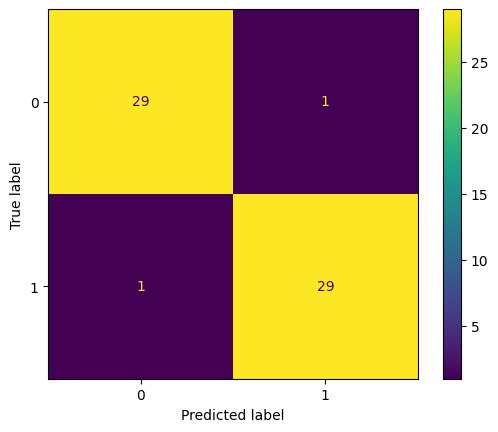

In [114]:
#######CONFUSION MATRIX ###########
from sklearn import metrics
y_test_pred_xgb = model_xgb.predict(X_test)
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test)
cm_display.plot()
plt.show()

In [115]:
total1=sum(sum(confusion_matrix_test))
#####from confusion matrix calculate accuracy
accuracy1=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.9666666666666667
Sensitivity :  0.9666666666666667
Specificity :  0.9666666666666667


#### The model achieved impressive consistency across accuracy, sensitivity, and specificity, with all metrics scoring 0.96, indicating its strong performance in correctly classifying both positive and negative samples.

# ROC curve

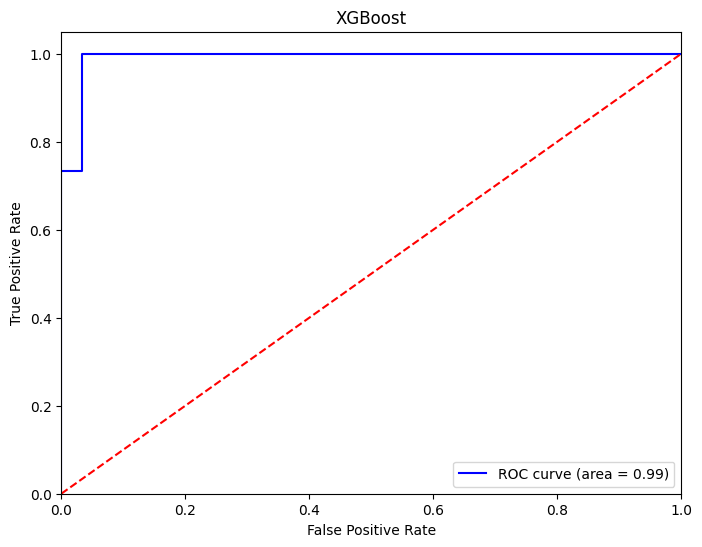

In [116]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost')
plt.legend(loc='lower right')
plt.show()

### The ROC curve above shows that the XGBoost model has an AUC of 0.99 which indicates that the model preformed good in classification of non cancer and cancer.

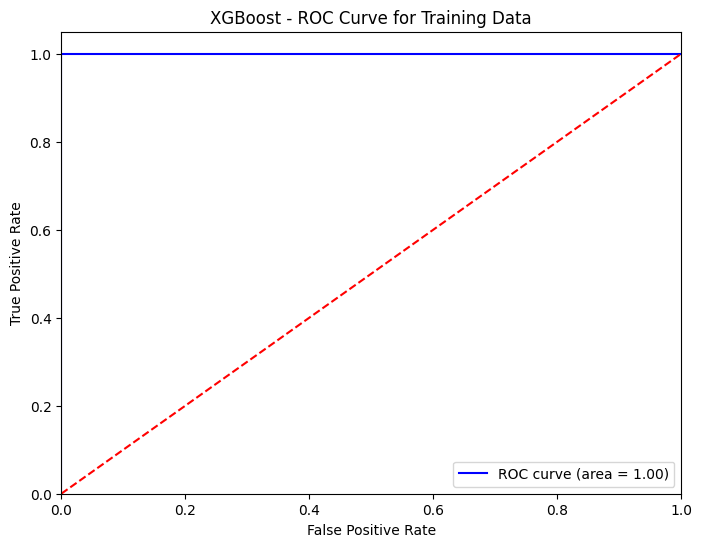

In [117]:
# Predict probabilities for the training data
y_train_proba = model_xgb.predict_proba(X_train)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)

# Calculate the area under the ROC curve (AUC) for training data
roc_auc_train = auc(fpr_train, tpr_train)

# Plot the ROC curve for training data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost - ROC Curve for Training Data')
plt.legend(loc='lower right')
plt.show()

#### In the ROC curve above we can see that the AUC value of 1 for the train set which indicates the model's flawless ability to distinguish between positive and negative classes during training, showcasing excellent performance on the training data.

# Feature importance

In [118]:
# for important features:
important_feat = model_xgb.feature_importances_
#get indices of those important features
idx = important_feat.argsort(kind= "quicksort")
idx= idx[::-1][:50]

In [119]:
idx

array([ 32, 212, 169, 137, 170,  83,  84, 101,   7, 140, 104,  17,  14,
       120, 135, 116, 103, 198, 136, 229,  22, 189, 217,  71,  77,  75,
        78,  79,  76,  74,  73,  72,  70,  80,  68,  67,  66,  65,  64,
        63,  62,  61,  69, 108, 106, 105, 102, 100,  99,  98])

In [120]:
df1 = X.T

In [121]:
top_met = df1.iloc[idx]

In [122]:
top_met.index

Index(['hsa-miR-130b-3p', 'hsa-miR-93-5p', 'hsa-miR-455-3p', 'hsa-miR-378i',
       'hsa-miR-455-5p', 'hsa-miR-21-3p', 'hsa-miR-21-5p', 'hsa-miR-29c-3p',
       'hsa-miR-100-5p', 'hsa-miR-424-5p', 'hsa-miR-30a-5p', 'hsa-miR-1246',
       'hsa-miR-1224-5p', 'hsa-miR-338-3p', 'hsa-miR-378a-3p',
       'hsa-miR-324-3p', 'hsa-miR-301a-3p', 'hsa-miR-582-5p', 'hsa-miR-378d',
       'mr_1', 'hsa-miR-126-3p', 'hsa-miR-497-5p', 'hsa-miR-99a-5p',
       'hsa-miR-197-3p', 'hsa-miR-19b-3p', 'hsa-miR-199a-5p',
       'hsa-miR-200b-3p', 'hsa-miR-200c-3p', 'hsa-miR-19a-3p',
       'hsa-miR-199a-3p', 'hsa-miR-1973', 'hsa-miR-197-5p', 'hsa-miR-195-5p',
       'hsa-miR-205-5p', 'hsa-miR-193a-5p', 'hsa-miR-1915-3p',
       'hsa-miR-18b-5p', 'hsa-miR-18a-5p', 'hsa-miR-188-5p', 'hsa-miR-185-5p',
       'hsa-miR-181b-5p', 'hsa-miR-181a-5p', 'hsa-miR-193b-3p', 'hsa-miR-3125',
       'hsa-miR-30c-5p', 'hsa-miR-30b-5p', 'hsa-miR-29c-5p', 'hsa-miR-29a-3p',
       'hsa-miR-296-5p', 'hsa-miR-27b-3p'],
      dtype

In [123]:
from xgboost import plot_importance

In [124]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'Xgboost Feature Importance')

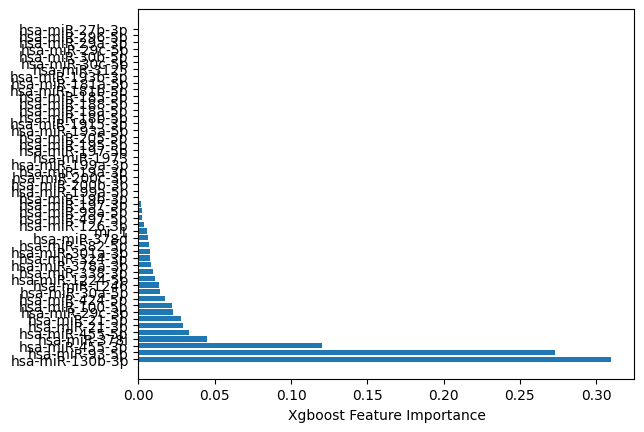

In [125]:
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(top_met.index, model_xgb.feature_importances_[idx])[::-1]
plt.xlabel("Xgboost Feature Importance")

#### The plot above shows the feature importance from low to high for top 50 genes